In [ ]:
import matplotlib 
from scholte import *

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

from seaborn import violinplot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from numpy.random import random_sample
from scipy.stats import linregress

from time import perf_counter
from tqdm import tqdm
import pickle



In [4]:
kobs0_manual = np.array([0.0343, 0.0305, 0.0246, 0.020, 0.0150, 0.0113, 0.0059, 0.0029, 0.00042])
fobs0_manual = np.array([1.335, 1.265, 1.125, 1.01, 0.88, 0.77, 0.585, 0.46, 0.378])
kobs1_manual = np.array([0.001, 0.002, 0.003, 0.004, 0.005])
fobs1_manual = np.array([0.756,   0.80, 0.835, 0.865, 0.90])

kobs = [kobs0_manual,kobs1_manual]
fobs = [fobs0_manual,fobs1_manual]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


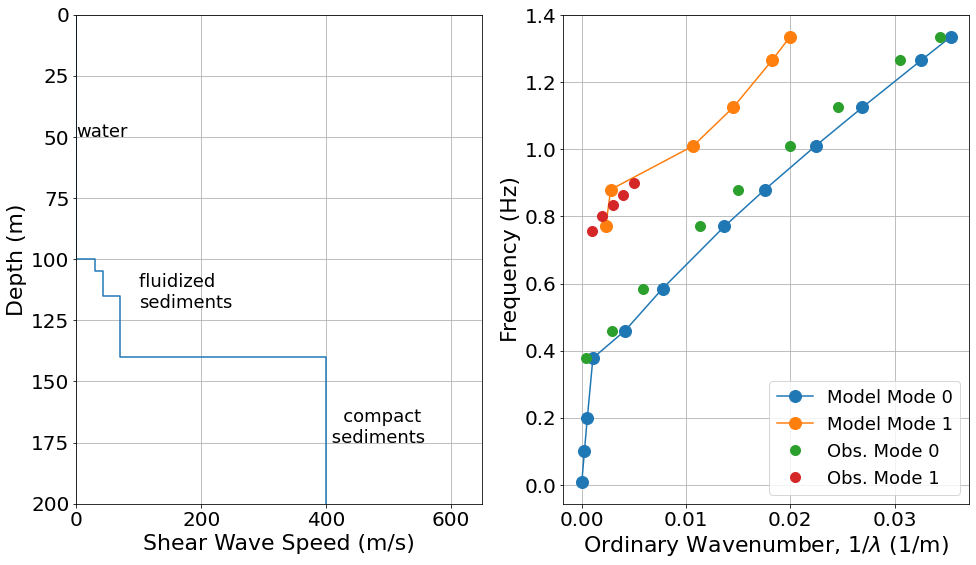

In [11]:
h =  [0.100, 0.005, 0.010, 0.025, 0.0]
vs = [0, 0.030, 0.043, 0.070, 0.400]
vp = [1.5,1.6,1.6,1.6,1.6]
rho= [1,1.5,1.5,1.5,1.5]

# Four layer model -- tuned for one mode!
# h =  [0.100, 0.005, 0.010, 0.025, 0.0]
# vs = [0, 0.038, 0.043, 0.080, 0.600]
# vp = [1.5,1.6,1.6,1.6,1.6]
# rho= [1,1.5,1.5,1.5,1.5]

# Three-layer model
# h =  [0.100, 0.005, 0.035, 0.0]
# vs = [0, 0.024, 0.06,  15.00]
# vp = [1.5,1.6,1.6,16.0]
# rho= [1,1.5,1.5,1.5]

f,k = pysurf96(h,vp,vs,rho)

plt_dispersion(f,k,fobs,kobs,
               np.hstack([0,np.cumsum(h)*1e3,200]),
               1000*np.hstack([vs,vs[-1],vs[-1]]),
              save=True)

# MCMC/MS on velocity structure

In [ ]:
import pickle
with open('100k_4param_MCMC.pickle', 'rb') as f:
    x_list = pickle.load(f)

In [ ]:
fig,ax=plt.subplots(figsize=(16,5))
fig.patch.set_facecolor('w')
ax.violinplot(x_list,positions=[5,15,40,100],widths=20,vert=False)
plt.ylim([110,-10])
plt.xlabel('Shear wave speed (m/s)',fontsize=20)
plt.ylabel('Depth below seafloor (m)',fontsize=20)
plt.grid()

In [ ]:
burnin_threshold = 0.33
print(f'Total accepted steps: {len(x_list)}')
print(f'Burn-in length: {round(len(x_list)*burnin_threshold)}')
x_list_subset=x_list[round(len(x_list)*burnin_threshold):-1,:]

In [ ]:
from scipy.stats import gaussian_kde

fig,ax=plt.subplots(4,4,figsize=(16,9))
fig.patch.set_facecolor('w')

plt.subplot(4,4,1)
plt.hist(x_list_subset[:,0],density=True, orientation='horizontal')
# plt.xlim([0.5,0])

plt.subplot(4,4,2)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,1]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,1],x_list_subset[:,0],c=z,cmap='Greys',s=5)

plt.subplot(4,4,3)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,2],x_list_subset[:,0],c=z,cmap='Greys',s=5)

plt.subplot(4,4,4)
xy = np.vstack([x_list_subset[:,0],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,0],c=z,cmap='Greys',s=5)




plt.subplot(4,4,6)
plt.hist(x_list_subset[:,1], density=True,orientation='horizontal')
# plt.xlim([100,0])

plt.subplot(4,4,7)
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,2]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,2],x_list_subset[:,1],c=z,cmap='Greys',s=5)

plt.subplot(4,4,8)
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,1],c=z,cmap='Greys',s=5)




plt.subplot(4,4,11)
plt.hist(x_list_subset[:,2],density=True, orientation='horizontal')
# plt.xlim([100,0])

plt.subplot(4,4,12)
xy = np.vstack([x_list_subset[:,2],x_list_subset[:,3]])
z = gaussian_kde(xy)(xy)
plt.scatter(x_list_subset[:,3],x_list_subset[:,2],c=z,cmap='Greys',s=5)



plt.subplot(4,4,16)
plt.hist(x_list_subset[:,3],density=True, orientation='horizontal')
# plt.xlim([100,0])

for ind in (5,9,10,13,14,15):
    plt.subplot(4,4,ind)
    plt.axis('off')

plt.tight_layout()
plt.savefig('mcmc.eps')

# Now do the same analysis but with variable layer thicknesses also

In [ ]:
import pickle
with open('100k_8param_MCMC.pickle', 'rb') as f:
    x_list = pickle.load(f)

In [ ]:
burnin_threshold = 0.33
print(f'Total accepted steps: {len(x_list)}')
print(f'Burn-in length: {round(len(x_list)*burnin_threshold)}')
x_list_subset=x_list[round(len(x_list)*burnin_threshold):-1,:]

In [ ]:
xy = np.vstack([x_list_subset[:,1],x_list_subset[:,5]])
z = gaussian_kde(xy)(xy)

In [ ]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.scatter(x_list_subset[:,5],x_list_subset[:,1],c=z,s=2.5,cmap='Greys')

In [ ]:
x_list_subset_noblank = np.delete(x_list_subset, 4, 1)
nvar = x_list_subset_noblank.shape[1]
fig,ax=plt.subplots(int(nvar/2),2,figsize=(16,18))
fig.patch.set_facecolor('w')
titles=['Water Depth',
       'Layer 1 Thickness',
       'Layer 2 Thickness',
       'Layer 3 Thickness',
       'Layer 1 Wavespeed',
       'Layer 2 Wavespeed',
       'Layer 3 Wavespeed',
       'Halfspace Wavespeed']

for i in range(nvar):
    
    ax=plt.subplot(int(nvar/2),2,i+1)
    ax.hist(x_list_subset_noblank[:,i],density=True)
    ax.title.set_text(titles[i])
    ax.title.set_fontsize(20)
plt.tight_layout()

In [ ]:

fig,ax=plt.subplots(nvar,nvar,figsize=(16,16))
fig.patch.set_facecolor('w')
ind=1
for j in range(nvar): # Column
    for i in range(nvar): # Row
        ax=plt.subplot(nvar,nvar,ind)
        if j > i:
            plt.axis('off')
        elif i==j:
            plt.hist(x_list_subset_noblank[:,i],density=True)
        else:
            xy = np.vstack([x_list_subset_noblank[:,i],x_list_subset_noblank[:,j]])
            z = gaussian_kde(xy)(xy)
            plt.scatter( x_list_subset_noblank[:,i] , 
                         x_list_subset_noblank[:,j] ,
                         s = 2.5,
                         c = z,
                         cmap = 'Greys')
        ind = ind+1
plt.tight_layout()

In [ ]:
np.median(x_list_subset_noblank,axis=0).round()/1e3

In [ ]:
# titles=['Water Depth',
#        'Layer 1 Thickness',
#        'Layer 2 Thickness',
#        'Layer 3 Thickness',
#        'Layer 1 Wavespeed',
#        'Layer 2 Wavespeed',
#        'Layer 3 Wavespeed',
#        'Halfspace Wavespeed']
HHH = np.sum(x_list[:,1:4],axis=1)
CCC = (x_list[:,4]*x_list[:,1] + x_list[:,5]*x_list[:,2] + x_list[:,6]*x_list[:,3])\
        /np.sum(x_list[:,4:7],axis=1)

In [ ]:
xy = np.vstack([HHH,CCC])
z = gaussian_kde(xy)(xy)

In [ ]:
NNN = x_list.shape[0]

In [ ]:
fig,ax=plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('w')
plt.scatter(HHH,CCC,c=z,s=2.5,cmap='Blues')
plt.xlabel('Sediment Layer Thickness (m)',fontsize=20)
plt.ylabel('Layer-Averaged S-Wave Speed (m/s)',fontsize=20)
plt.grid()
plt.savefig('mcmc_averaged.png')